In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('paper', font_scale=1.18)

In [2]:
threshold = 50

In [3]:
mimic_names = {'hypotension_diagnosed': 'hypotension', 'anemia_diagnosed': 'anemia',
               'purpura_diagnosed': 'purpura', 'respiratory_diagnosed': 'respiratory diseases',
               'hypertensive_diagnosed': 'hypertension', 'lipoid_diagnosed': 'lipoid disorders',
               'diabetes_diagnosed': 'diabetes', 'overweight_diagnosed': 'obesity',
               'alcohol_diagnosed': 'alcohol dependence', 'atrial_diagnosed': 'atrial fibrillation',
               'ischematic_diagnosed': 'ischematic diseases', 'heart_diagnosed': 'heart failure'}
df_cols = {}
for cols in (10, 20, 50, 100):
    results_mimic = pd.read_csv(f'../5_metaMIMIC_experiment_3/results_{cols}.csv')
    df_mimic = results_mimic.groupby(['set_index', 'target', 'half']).agg({'AUC': 'mean'}).reset_index().copy()
    df_mimic = df_mimic.loc[df_mimic['set_index']!=999]
    df_mimic.loc[:, 'columns'] = np.repeat(cols, len(df_mimic))
    df_mimic.loc[:, 'target'] =  df_mimic.loc[:, 'target'].map(mimic_names)
    df_cols[f'df_mimic_{cols}'] = df_mimic
results_mimic_172 = pd.read_csv('../3_metaMIMIC_experiment_2/results.csv')
df_mimic_172 = results_mimic_172.groupby(['set_index', 'target', 'half']).agg({'AUC': 'mean'}).reset_index().copy()
df_mimic_172 = df_mimic_172.loc[df_mimic_172['set_index']!=999]
df_mimic_172.loc[:, 'columns'] = np.repeat(172, len(df_mimic))
df_mimic_172.loc[:, 'target'] =  df_mimic_172.loc[:, 'target'].map(mimic_names)
df_cols['df_mimic_172'] = df_mimic_172
df_mimic = pd.concat(df_cols.values(), ignore_index=True)
df_mimic

,set_index,target,half,AUC,columns
0,0,alcohol dependence,1,0.781135,10
1,0,alcohol dependence,2,0.781096,10
2,0,anemia,1,0.755870,10
3,0,anemia,2,0.764343,10
4,0,atrial fibrillation,1,0.847504,10
...,...,...,...,...,...
119875,998,obesity,2,0.499758,172
119876,998,purpura,1,0.502272,172
119877,998,purpura,2,0.600437,172
119878,998,respiratory diseases,1,0.499754,172


In [4]:
results_openml = pd.read_csv('../mementoML_results/results.csv')
df_openml = results_openml.copy()
df_openml.columns = ['target', 'set_index', 'AUC']
openml_names = {37: 'diabetes', 44: 'spambase', 1043: 'ada_agnostic', 1046: 'mozilla4', 1049: 'pc4', 1050: 'pc3',
            1063: 'kc2', 1067: 'kc1', 1068: 'pc1', 1120: 'MagicTelescope', 1462: 'banknote-authentication',
            1464: 'blood-transfusion', 1467: 'climate-model', 1471: 'eeg-eye-state',
            1479: 'hill-valley', 1485: 'madelon', 1487: 'ozone-level-8hr', 1489: 'phoneme', 1494: 'qsar-biodeg',
            1504: 'steel-plates-fault', 1510: 'wdbc', 1570: 'wilt'}
df_openml.loc[:, 'target'] = df_openml.loc[:, 'target'].map(openml_names)
df_openml

,target,set_index,AUC
0,diabetes,0,0.768046
1,diabetes,1,0.830233
2,diabetes,2,0.798156
3,diabetes,3,0.813763
4,diabetes,4,0.763103
...,...,...,...
21973,wilt,994,0.828950
21974,wilt,995,0.966634
21975,wilt,996,0.927657
21976,wilt,997,0.978009


In [5]:
heatmaps = {}
columns = (10, 20, 50, 100, 172)
n_1 = len(columns)
targets_mimic = np.unique(df_mimic['target'])
n_2 = len(targets_mimic)
for x in (1, 2):
    for y in (1, 2):
        heatmap = pd.DataFrame(index=columns, columns=columns, dtype=float)
        for i in range(n_1):
            for j in range(n_1):
                temp = pd.DataFrame(index=targets_mimic, columns=targets_mimic, dtype=int)
                for k in range(n_2):
                    for l in range(n_2):
                        if k == l:
                            temp.iloc[k, l] = None
                            continue
                        sets_1 = df_mimic[(df_mimic['target']==targets_mimic[k]) & (df_mimic['half']==x) & (df_mimic['columns']==columns[i])].sort_values('AUC', ascending=False).iloc[:threshold, :]
                        sets_2 = df_mimic[(df_mimic['target']==targets_mimic[l]) & (df_mimic['half']==y) & (df_mimic['columns']==columns[j])].sort_values('AUC', ascending=False).iloc[:threshold, :]
                        temp.iloc[k, l] = len(set(sets_1['set_index']).intersection(set(sets_2['set_index'])))
                heatmap.iloc[i, j] = np.nanmean(temp.values.reshape(-1))
        heatmaps[f'heatmap_{x}_{y}'] = heatmap

In [6]:
heatcols = {}
columns = (10, 20, 50, 100, 172)
n_1 = len(columns)
targets_mimic = np.unique(df_mimic['target'])
n_2 = len(targets_mimic)
targets_openml = np.unique(df_openml['target'])
n_3 = len(targets_openml)
for x in (1, 2):
    heatcol = pd.Series(index=columns, dtype=float)
    for i in range(n_1):
        temp = pd.DataFrame(index=targets_mimic, columns=targets_openml, dtype=int)
        for k in range(n_2):
            for l in range(n_3):
                sets_1 = df_mimic[(df_mimic['target']==targets_mimic[k]) & (df_mimic['half']==x) & (df_mimic['columns']==columns[i])].sort_values('AUC', ascending=False).iloc[:threshold, :]
                sets_2 = df_openml[df_openml['target']==targets_openml[l]].sort_values('AUC', ascending=False).iloc[:threshold, :]
                temp.iloc[k, l] = len(set(sets_1['set_index']).intersection(set(sets_2['set_index'])))
        heatcol.iloc[i] = np.nanmean(temp.values.reshape(-1))
    heatcols[f'heatcol_{x}'] = heatcol

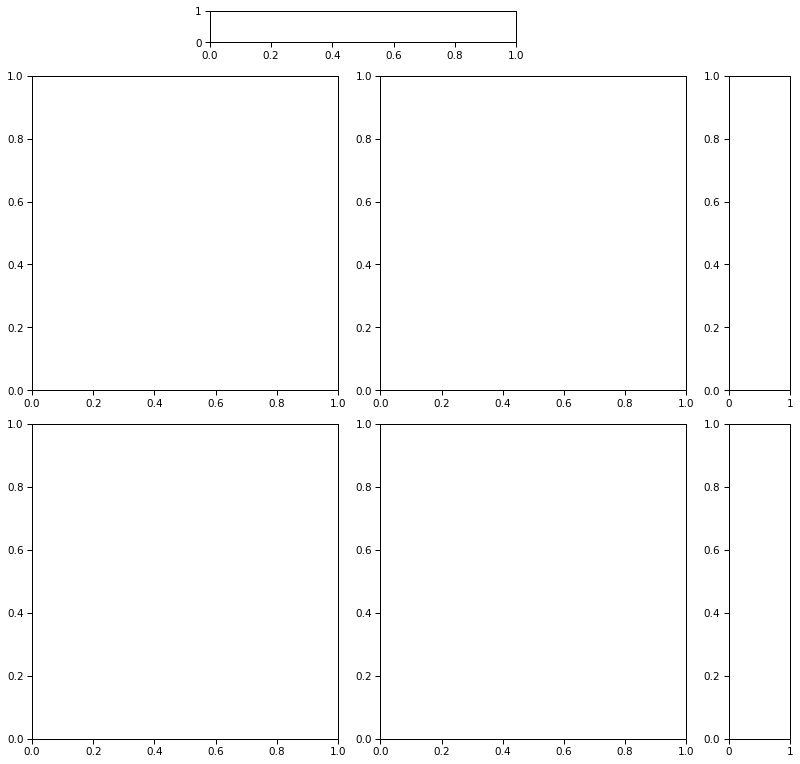

In [7]:
fig = plt.figure(figsize=(11, 10.5), constrained_layout=True)
gs = fig.add_gridspec(nrows=3, ncols=5, height_ratios=(1, 10, 10), width_ratios=(2.5, 2.5, 2.5, 2.5, 1))
ax_1 = fig.add_subplot(gs[1, 0:2])
ax_2 = fig.add_subplot(gs[1, 2:4])
ax_3 = fig.add_subplot(gs[2, 0:2])
ax_4 = fig.add_subplot(gs[2, 2:4])
ax_5 = fig.add_subplot(gs[0, 1:3])
ax_6 = fig.add_subplot(gs[1, 4])
ax_6 = fig.add_subplot(gs[2, 4])

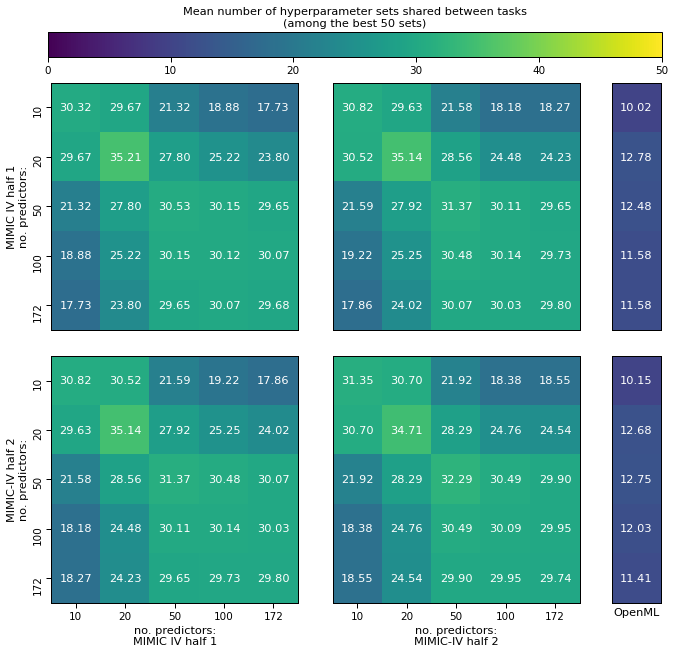

In [8]:
fig = plt.figure(figsize=(11, 10.5), constrained_layout=False)
gs = fig.add_gridspec(nrows=3, ncols=3, height_ratios=(1, 10, 10), width_ratios=(5, 5, 1), hspace=0.15, wspace=0.15)
ax_1 = fig.add_subplot(gs[1, 0], xmargin=0)
ax_2 = fig.add_subplot(gs[1, 1])
# ax_12 = fig.add_subplot(gs[1, 0:2], frameon=False)
ax_3 = fig.add_subplot(gs[2, 0])
ax_4 = fig.add_subplot(gs[2, 1])
ax_5 = fig.add_subplot(gs[0, 0:4])
ax_6 = fig.add_subplot(gs[1, 2])
ax_7 = fig.add_subplot(gs[2, 2])

sns.heatmap(heatmaps['heatmap_1_1'], ax=ax_1, cmap='viridis', vmin=0, vmax=threshold, square=True, cbar=False, annot=True, fmt='.2f')
ax_1.set_ylabel('MIMIC IV half 1\nno. predictors:')
ax_1.set_xticks([])
for _, spine in ax_1.spines.items():
    spine.set_visible(True)
    
sns.heatmap(heatmaps['heatmap_1_2'], ax=ax_2, cmap='viridis', vmin=0, vmax=threshold, square=True, cbar=False, annot=True, fmt='.2f')
ax_2.set_xticks([])
ax_2.set_yticks([])
for _, spine in ax_2.spines.items():
    spine.set_visible(True)

# ax_12.set_xticks([])
# ax_12.set_yticks([])
# ax_12.set_title(f'MIMIC-IV vs MIMIC-IV')
    
sns.heatmap(heatmaps['heatmap_2_1'], ax=ax_3, cmap='viridis', vmin=0, vmax=threshold, square=True, cbar=False, annot=True, fmt='.2f')
ax_3.set_xlabel('no. predictors:\nMIMIC IV half 1')
ax_3.set_ylabel('MIMIC-IV half 2\nno. predictors:')
for _, spine in ax_3.spines.items():
    spine.set_visible(True)
    
sns.heatmap(heatmaps['heatmap_2_2'], ax=ax_4, cmap='viridis', vmin=0, vmax=threshold, square=True, cbar=False, annot=True, fmt='.2f')
ax_4.set_xlabel('no. predictors:\nMIMIC-IV half 2')
ax_4.set_yticks([])
for _, spine in ax_4.spines.items():
    spine.set_visible(True)
    
plt.colorbar(ax_1.get_children()[0], cax=ax_5, orientation='horizontal')
ax_5.set_title(f'Mean number of hyperparameter sets shared between tasks\n(among the best {threshold} sets)')

sns.heatmap(pd.DataFrame(heatcols['heatcol_1']), ax=ax_6, cmap='viridis', vmin=0, vmax=threshold, square=True, cbar=False, annot=True, fmt='.2f')
ax_6.set_xticks([])
ax_6.set_yticks([])
for _, spine in ax_6.spines.items():
    spine.set_visible(True)

sns.heatmap(pd.DataFrame(heatcols['heatcol_2']), ax=ax_7, cmap='viridis', vmin=0, vmax=threshold, square=True, cbar=False, annot=True, fmt='.2f')
ax_7.set_xlabel(f'OpenML')
ax_7.set_xticks([])
ax_7.set_yticks([])
for _, spine in ax_7.spines.items():
    spine.set_visible(True)

fig.set_constrained_layout_pads(w_pad=1/10, h_pad=1/10, hspace=0.3, wspace=0.3)
    
plt.savefig('./results_2.pdf', format='pdf', bbox_inches='tight')